# Graphing Results

## Setup

In [1]:
import os
import multiprocessing
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from PopulationClass import Population
from PopulationParameters import PopulationParameters

In [2]:
def draw_graph(pop, graph, graph_pos, outfile):
    color_map = []
    for node in graph:
        if pop.players[node].real:
            color_map.append((0.8, 0.8, 0.8))
        elif pop.players[node].fake:
            color_map.append((0.4, 0.4, 0.4))
        elif pop.players[node].factcheck:
            color_map.append((0.1, 0.1, 0.8))
        else:
            color_map.append((0.8, 0.1, 0.1))
    plt.subplots()
    nx.draw(graph, graph_pos, with_labels=True, node_color=color_map)
    if outfile is not None: 
        plt.savefig(outfile, dpi=600)
    plt.show()
    plt.close()

## Run 1: Test

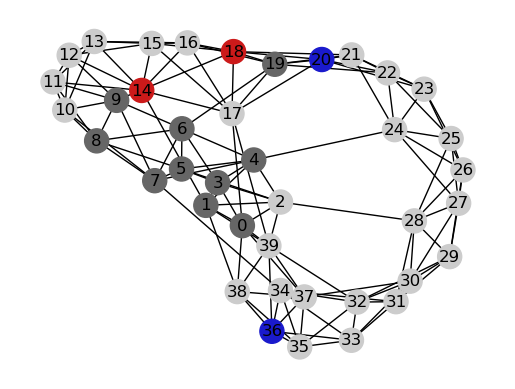

In [3]:
# All Population Structures
pop = Population("smallworld", pop_size=40, c=6, p=0.1)
pop.set_all_nodes_realnews()
pop.add_contig_fakenews_nodes(10)
pop.add_factchecker_nodes(2)
pop.add_misinfor_nodes(2)
num_factcheckers = 2
num_misinformers = 2

# Used to draw graphs. Initialize this once at the beginning.
graph = nx.from_pandas_edgelist(pop.edgelist, "lowindx", "highindx")
graph_pos = nx.spring_layout(graph, iterations=2000)  # circular layout alternate
draw_graph(pop, graph, graph_pos, None)

In [4]:
simulation_time_cutoff = 100
# y: if the system hasn't changed for `stabilization_time` timesteps,
#    mark the system as "stabilized" (or "in a loop", depends).
simulation_stabilization_cutoff = 20

# Snapshot current node state
# (True => real, False => fake, factchecker, or misinformer). Used to detect loops.
current_state_snapshot = pop.get_realnews_list()
old_state_snapshot = [True] * pop.pop_size
fakenews_per_tick = [] # Metrics
ticks_since_last_change = 0 # used for loop detection

# Run the simulation to a steady state, or until timeout.
for simulation_timer in range(simulation_time_cutoff):
    pop.update_step()

    fakenews_per_tick.append(pop.get_total_fakenews_count() / pop.pop_size)

    #draw_graph(pop, graph, graph_pos, f"step-{simulation_timer}.png")

    older_state_snapshot = old_state_snapshot
    old_state_snapshot = current_state_snapshot
    current_state_snapshot = pop.get_realnews_list()
    reals = pop.get_total_realnews_count()

    # Detect if a strategy has completely fixated
    if reals == pop.pop_size - num_factcheckers - num_misinformers:
        print("The real news strategy has completely fixated")
        break
    if reals == 0:
        print("The fake news strategy has completely fixated")
        break

    # Detect if the system has reached a fixed state.
    if old_state_snapshot == current_state_snapshot:
        ticks_since_last_change += 1
    else:
        ticks_since_last_change = 0

    if ticks_since_last_change == simulation_stabilization_cutoff:
        print("The system has reached a fixed state")
        if reals >= (pop.pop_size - num_factcheckers - num_misinformers) / 2:
            print("The real news strategy has more players")
        else:
            print("The fake news strategy has more players")
        break

    # TODO what happens when we run out of time?


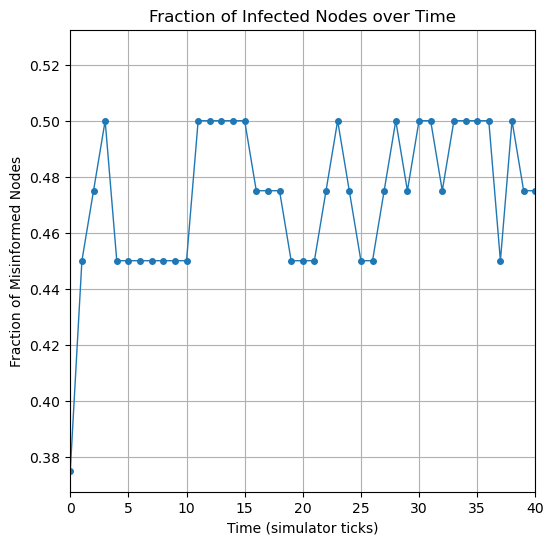

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(fakenews_per_tick, marker='o', linestyle='-', linewidth=1, markersize=4)
plt.title("Fraction of Infected Nodes over Time")
plt.xlabel("Time (simulator ticks)")
plt.xlim(0, 40)
plt.ylabel("Fraction of Misinformed Nodes")
plt.grid(True)
#plt.savefig('infection-plot.png', dpi=600)
plt.show()

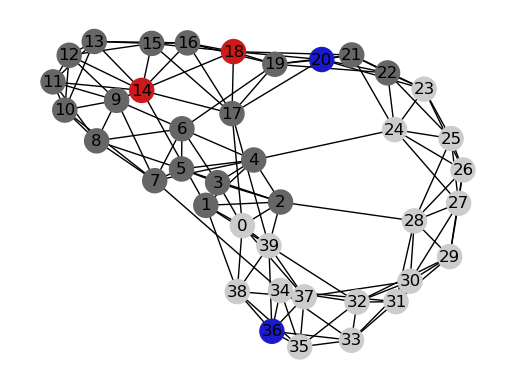

In [6]:
draw_graph(pop, graph, graph_pos, None)

## Run 2: Testing Viral Carrying Capacity Under Different Topologies and Attacks

In [7]:
pop_size = 100

In [8]:
def run_simulation(pop): 
    simulation_time_cutoff = 150
    # y: if the system hasn't changed for `stabilization_time` timesteps,
    #    mark the system as "stabilized" (or "in a loop", depends).
    simulation_stabilization_cutoff = 20
    
    # Snapshot current node state
    # (True => real, False => fake, factchecker, or misinformer). Used to detect loops.
    current_state_snapshot = pop.get_realnews_list()
    old_state_snapshot = [True] * pop.pop_size
    fakenews_per_tick = [] # Metrics
    ticks_since_last_change = 0 # used for loop detection
    
    # Run the simulation to a steady state, or until timeout.
    for simulation_timer in range(simulation_time_cutoff):
        pop.update_step()
    
        #draw_graph(pop, graph, graph_pos, f"step-{simulation_timer}.png")
    
        old_state_snapshot = current_state_snapshot
        current_state_snapshot = pop.get_realnews_list()
        [num_reals, num_fakes, num_factcheckers, num_misinformers] = pop.count_all_strategies()

        fakenews_per_tick.append(num_fakes / (num_reals + num_fakes))

        # Detect if a strategy has completely fixated
        if num_reals == pop.pop_size - num_factcheckers - num_misinformers:
            #print("The real news strategy has completely fixated")
            break
        if num_reals == 0:
            #print("The fake news strategy has completely fixated")
            break
    
        # Detect if the system has reached a fixed state.
        if old_state_snapshot == current_state_snapshot:
            ticks_since_last_change += 1
        else:
            ticks_since_last_change = 0
    
        if ticks_since_last_change == simulation_stabilization_cutoff:
            #print("The system has reached a fixed state")
            #if reals >= (pop.pop_size - num_factcheckers - num_misinformers) / 2:
                #print("The real news strategy has more players")
            break
    
    return fakenews_per_tick


### Small World Topologies: Uniform Random Attack

In [9]:
infection_loads = np.arange(0.1, 1.0, 0.1)
infection_outcomes = []
for infection_load in infection_loads: 
    # First, let's generate a bunch of topologies. 
    topology_batch = []
    for _ in range(25): 
        pop = Population("smallworld", pop_size=pop_size, c=6, p=0.1)
        pop.set_all_nodes_realnews()
        pop.add_fakenews_nodes(infection_load * pop_size)
        pop.add_factchecker_nodes(pop_size / 25)
        pop.add_misinfor_nodes(pop_size / 25)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results))
        
    infection_outcomes.append(results)    

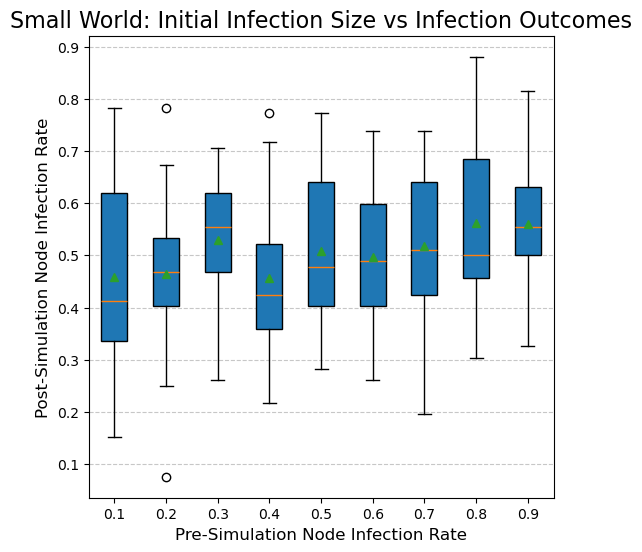

In [10]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

# Customize the plot
plt.title("Small World: Initial Infection Size vs Infection Outcomes", fontsize=16)
plt.xlabel("Pre-Simulation Node Infection Rate", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in infection_loads]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/smallworld-uniform-attack-carrying-capacity.png', dpi=600)
plt.show()

### Small World Topologies: Contiguous Random Attack

In [11]:
infection_loads = np.arange(0.1, 1.0, 0.1)
infection_outcomes = []
for infection_load in infection_loads: 
    # First, let's generate a bunch of topologies. 
    topology_batch = []
    for _ in range(25): 
        pop = Population("smallworld", pop_size=pop_size, c=6, p=0.1)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(infection_load * pop_size)
        pop.add_factchecker_nodes(pop_size / 25)
        pop.add_misinfor_nodes(pop_size / 25)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results))
        
    infection_outcomes.append(results)    

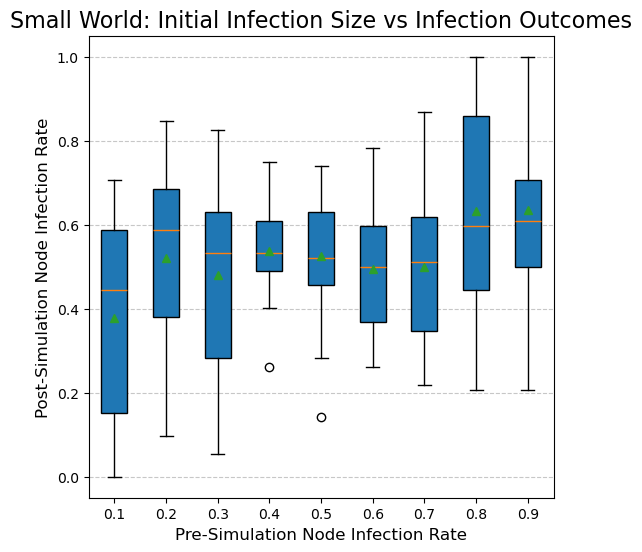

In [12]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

# Customize the plot
plt.title("Small World: Initial Infection Size vs Infection Outcomes", fontsize=16)
plt.xlabel("Pre-Simulation Node Infection Rate", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in infection_loads]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/smallworld-concentrated-attack-carrying-capacity.png', dpi=600)
plt.show()

Conclusion: __Contiguous attacks are more effective on small-world topologies__...at least for degrees we've tried so far. 

Most of the time, the attack will be the same. But contiguity really increases the ceiling you can reach. 

"Wave Front", fewer pockets. 

### Thicker Small World Topologies: Assessing Viral Load

Does thickness help us resist attacks? 

In [13]:
c_list = np.arange(1, 20, 2)
infection_outcomes = []

for c in c_list: 
    # First, let's generate a bunch of topologies. 
    topology_batch = []
    for _ in range(25): 
        pop = Population("smallworld", pop_size=pop_size, c=c, p=0.1)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(0.2 * pop_size)
        pop.add_factchecker_nodes(pop_size / 25)
        pop.add_misinfor_nodes(pop_size / 25)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results)) 
    infection_outcomes.append(results)    

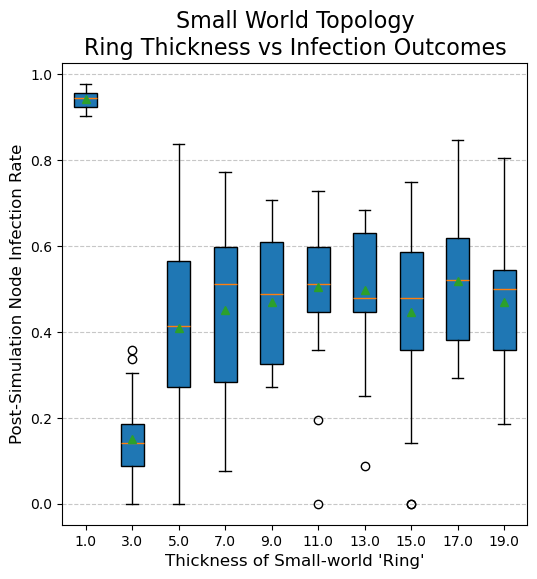

In [14]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

# Customize the plot
plt.title("Small World Topology\nRing Thickness vs Infection Outcomes", fontsize=16)
plt.xlabel("Thickness of Small-world 'Ring'", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in c_list]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/connectedness-rate-concentrated-attack-ring-thickness.png', dpi=600)
plt.show()

What about ring connection density? 

In [15]:
p_list = np.arange(0, 1, 0.05)
infection_outcomes = []

for p in p_list: 
    # First, let's generate a bunch of topologies. 
    topology_batch = []
    for _ in range(25): 
        pop = Population("smallworld", pop_size=pop_size, c=4, p=p)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(0.2 * pop_size)
        pop.add_factchecker_nodes(pop_size / 25)
        pop.add_misinfor_nodes(pop_size / 25)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results)) 
    infection_outcomes.append(results)    

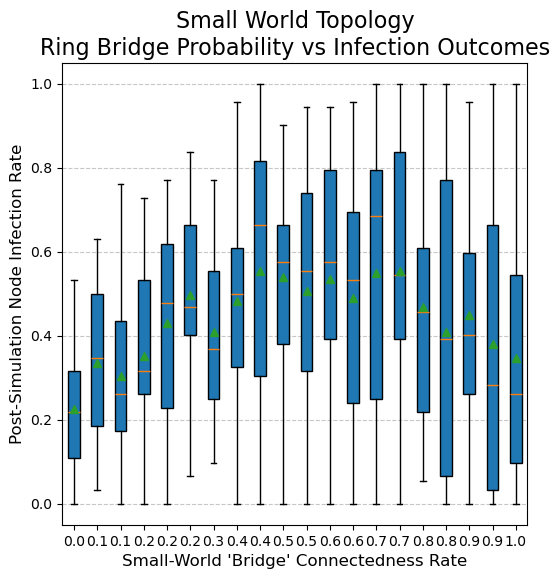

In [16]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

# Customize the plot
plt.title("Small World Topology\nRing Bridge Probability vs Infection Outcomes", fontsize=16)
plt.xlabel("Small-World 'Bridge' Connectedness Rate", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in p_list]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/connectedness-rate-concentrated-attack-ring-bridge.png', dpi=600)
plt.show()

__Conclusion__: The more thicker, the closer we get to reaching our "carrying capacity". Artifact of topology construction, can see cool things. 

But random bridges add unpredictability. Probability of cascades is high for both sides => greater outcome variability. 

### Random Topologies: Uniform Random Attack

In [17]:
# Then, Scale Free Topologies

infection_loads = np.arange(0.1, 1.0, 0.1)
infection_outcomes = []

for infection_load in infection_loads: 
    topology_batch = []
    for _ in range(25): 
        pop = Population("random", pop_size=pop_size, p=0.2)
        pop.set_all_nodes_realnews()
        pop.add_fakenews_nodes(infection_load * pop_size)
        pop.add_factchecker_nodes(pop_size / 25)
        pop.add_misinfor_nodes(pop_size / 25)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results))  
    infection_outcomes.append(results)    

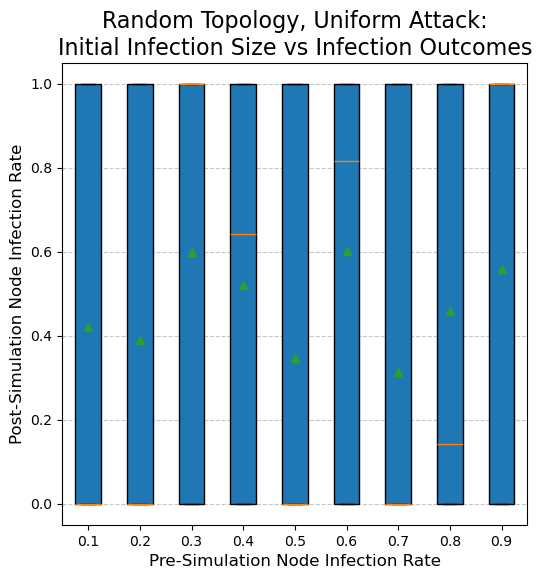

In [18]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

plt.title("Random Topology, Uniform Attack:\nInitial Infection Size vs Infection Outcomes", fontsize=16)
plt.xlabel("Pre-Simulation Node Infection Rate", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in infection_loads]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/random-uniform-attack-carrying-capacity.png', dpi=600)
plt.show()

### Random Topologies: Contig Random Attack

In [19]:
infection_loads = np.arange(0.1, 1.0, 0.1)
infection_outcomes = []

for infection_load in infection_loads: 
    topology_batch = []
    for _ in range(25): 
        pop = Population("random", pop_size=pop_size, p=0.2)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(infection_load * pop_size)
        pop.add_factchecker_nodes(pop_size / 25)
        pop.add_misinfor_nodes(pop_size / 25)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results))  
    infection_outcomes.append(results)    

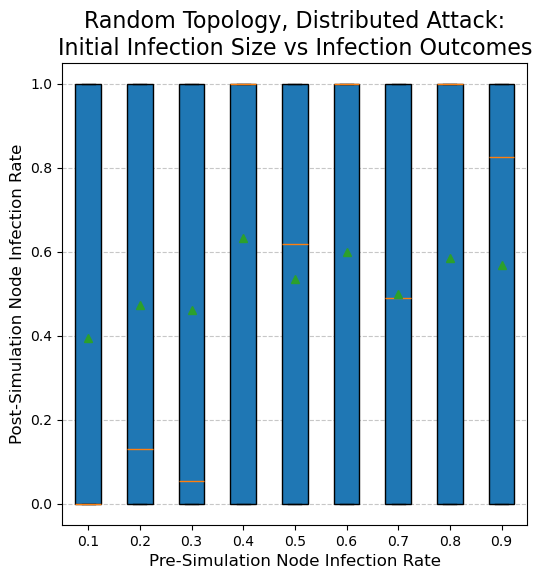

In [20]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

plt.title("Random Topology, Distributed Attack:\nInitial Infection Size vs Infection Outcomes", fontsize=16)
plt.xlabel("Pre-Simulation Node Infection Rate", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in infection_loads]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/random-concentrated-attack-carrying-capacity.png', dpi=600)
plt.show()

__Conclusion__: Random Attack means _random_! Almost entirely dependent on topology + initial params, _not_ infection rate. 

### Random Topology: Assessing Density

In [21]:
p_list = np.arange(0, 1, 0.05)
infection_outcomes = []

for p in p_list: 
    # First, let's generate a bunch of topologies. 
    topology_batch = []
    for _ in range(25): 
        pop = Population("random", pop_size=pop_size, p=p)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(0.2 * pop_size)
        pop.add_factchecker_nodes(pop_size / 25)
        pop.add_misinfor_nodes(pop_size / 25)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results)) 
    infection_outcomes.append(results)    

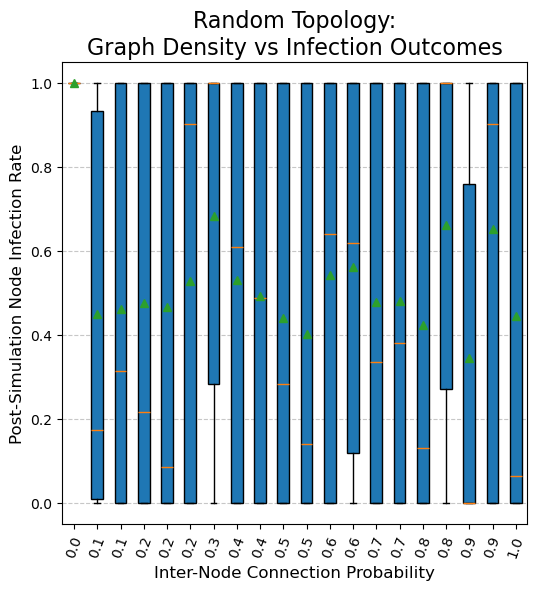

In [22]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

plt.title("Random Topology:\nGraph Density vs Infection Outcomes", fontsize=16)
plt.xlabel("Inter-Node Connection Probability", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in p_list]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels, rotation=70)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/random-concentrated-attack-density-effect.png', dpi=600)
plt.show()

### Scale Free Topology: Comparing Attack Models

In [23]:
# Scale Free: Uniform Attack Viral Load

infection_loads = np.arange(0.1, 1.0, 0.1)
infection_outcomes = []

for infection_load in infection_loads: 
    topology_batch = []
    for _ in range(25): 
        pop = Population("scalefree", c=2)
        pop.set_all_nodes_realnews()
        pop.add_fakenews_nodes(infection_load * pop_size)
        pop.add_factchecker_nodes(pop_size / 25)
        pop.add_misinfor_nodes(pop_size / 25)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results))  
    infection_outcomes.append(results)    

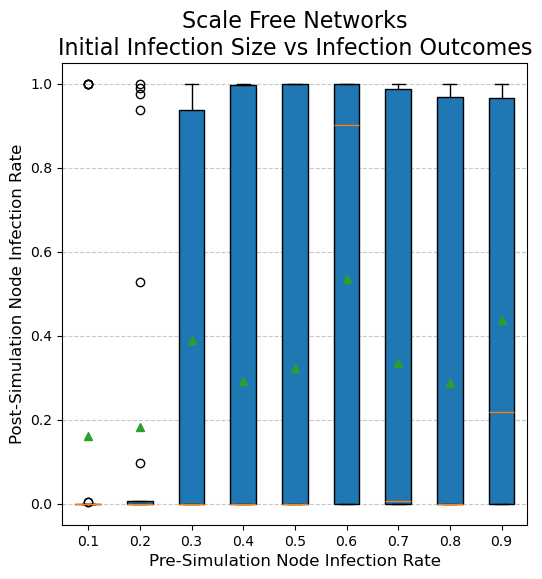

In [24]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

plt.title("Scale Free Networks\nInitial Infection Size vs Infection Outcomes", fontsize=16)
plt.xlabel("Pre-Simulation Node Infection Rate", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in infection_loads]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/scalefree-uniform-attack-carrying-capacity.png', dpi=600)
plt.show()

In [25]:
# Scale Free: Contig Attack Viral Load

infection_loads = np.arange(0.1, 1.0, 0.1)
infection_outcomes = []

for infection_load in infection_loads: 
    topology_batch = []
    for _ in range(25): 
        pop = Population("scalefree", c=2)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(infection_load * pop_size)
        pop.add_factchecker_nodes(pop_size / 25)
        pop.add_misinfor_nodes(pop_size / 25)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results))  
    infection_outcomes.append(results)    

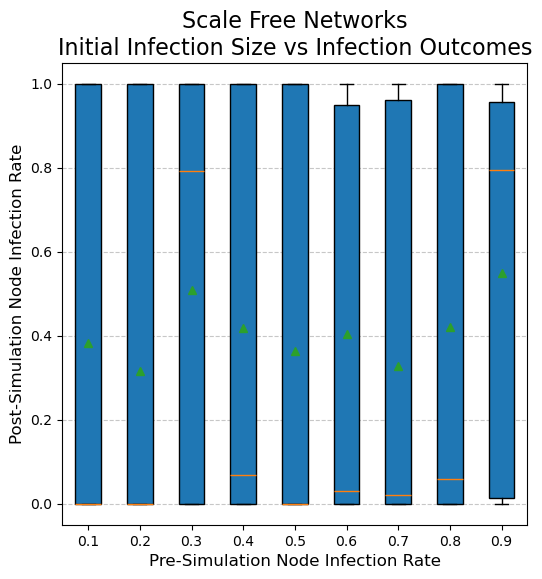

In [26]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

plt.title("Scale Free Networks\nInitial Infection Size vs Infection Outcomes", fontsize=16)
plt.xlabel("Pre-Simulation Node Infection Rate", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in infection_loads]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/scalefree-concentrated-attack-carrying-capacity.png', dpi=600)
plt.show()

#### Scale Free: Testing Connectivity

In [27]:
c_list = np.arange(0, 30, 5)
infection_outcomes = []

for c in c_list: 
    # First, let's generate a bunch of topologies. 
    topology_batch = []
    for _ in range(25): 
        pop = Population("scalefree", pop_size=pop_size, c=c)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(0.2 * pop_size)
        pop.add_factchecker_nodes(pop_size / 25)
        pop.add_misinfor_nodes(pop_size / 25)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results)) 
    infection_outcomes.append(results)    

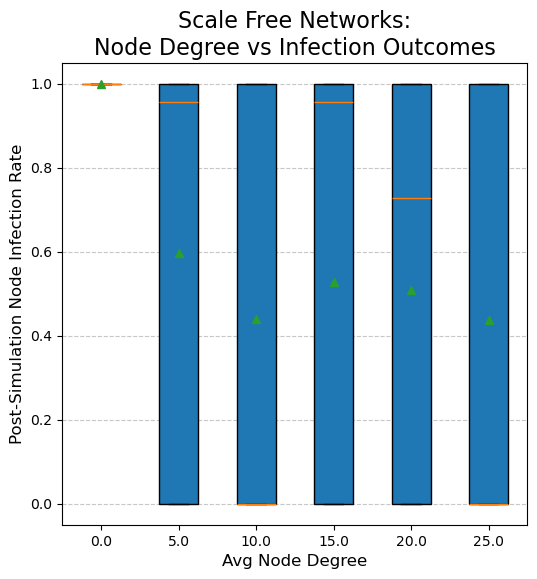

In [28]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

plt.title("Scale Free Networks:\nNode Degree vs Infection Outcomes", fontsize=16)
plt.xlabel("Avg Node Degree", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in c_list]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/scalefree-concentrated-attack-connectivity.png', dpi=600)
plt.show()

Now for the big question: _why_ is scale free so random? Let's look at some graphs. 

### Mechanism for ScaleFree

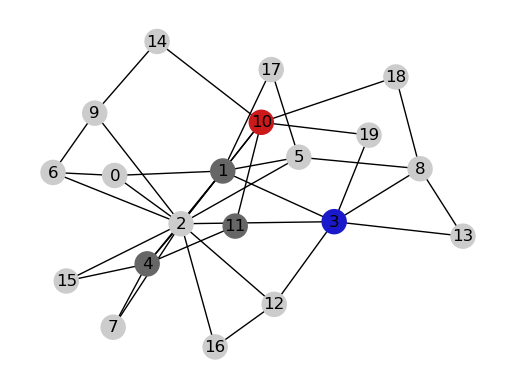

In [29]:
_pop_size = 20
pop = Population("scalefree", pop_size=_pop_size, c=2)
pop.set_all_nodes_realnews()
pop.add_contig_fakenews_nodes(0.2 * _pop_size)
pop.add_factchecker_nodes(_pop_size / 25)
pop.add_misinfor_nodes(_pop_size / 25)
# Used to draw graphs. Initialize this once at the beginning.
graph = nx.from_pandas_edgelist(pop.edgelist, "lowindx", "highindx")
graph_pos = nx.spring_layout(graph, iterations=2000)  # circular layout alternate
draw_graph(pop, graph, graph_pos, 'fig/scale-free-network-initial-state.png')

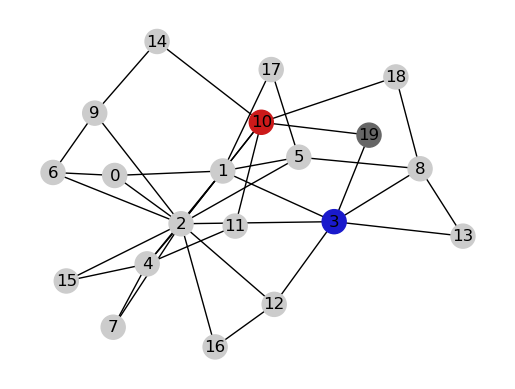

In [30]:
results = run_simulation(pop)  
draw_graph(pop, graph, graph_pos, None)

__Conclusion__: Variation is exclusively in terms of: Who has the high degrees. 

## Run 3: Understanding Spread of Intelligence

In [31]:
intelligences = np.arange(1, 2, 0.1)
infection_outcomes = []
for intelligence in intelligences: 
    # First, let's generate a bunch of topologies. 
    topology_batch = []
    for _ in range(25): 
        param = PopulationParameters(
            real_from_misinfor=-3.0 * (1 / intelligence), 
            real_from_real=1.0 * intelligence, 
            fake_from_factcheck=-2 * intelligence, 
            fake_from_real=-0.5 * intelligence)
        pop = Population("smallworld", pop_size=pop_size, c=6, p=0.1, pop_params=param)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(0.2 * pop_size)
        pop.add_factchecker_nodes(pop_size / 20)
        pop.add_misinfor_nodes(pop_size / 20)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results))
        
    infection_outcomes.append(results)    

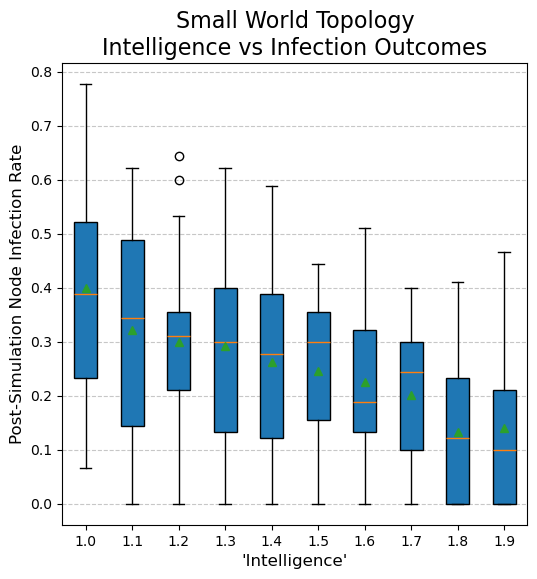

In [32]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

plt.title("Small World Topology\nIntelligence vs Infection Outcomes", fontsize=16)
plt.xlabel("'Intelligence'", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in intelligences]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/smallworld-intelligences.png', dpi=600)
plt.show()

In [33]:
intelligences = np.arange(1, 2, 0.1)
infection_outcomes = []
for intelligence in intelligences: 
    # First, let's generate a bunch of topologies. 
    topology_batch = []
    for _ in range(25): 
        param = PopulationParameters(
            real_from_misinfor=-3.0 * (1 / intelligence), 
            real_from_real=1.0 * intelligence, 
            fake_from_factcheck=-2 * intelligence, 
            fake_from_real=-0.5 * intelligence)
        pop = Population("random", pop_size=pop_size, p=0.4, pop_params=param)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(0.2 * pop_size)
        pop.add_factchecker_nodes(pop_size / 20)
        pop.add_misinfor_nodes(pop_size / 20)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results))
        
    infection_outcomes.append(results)    

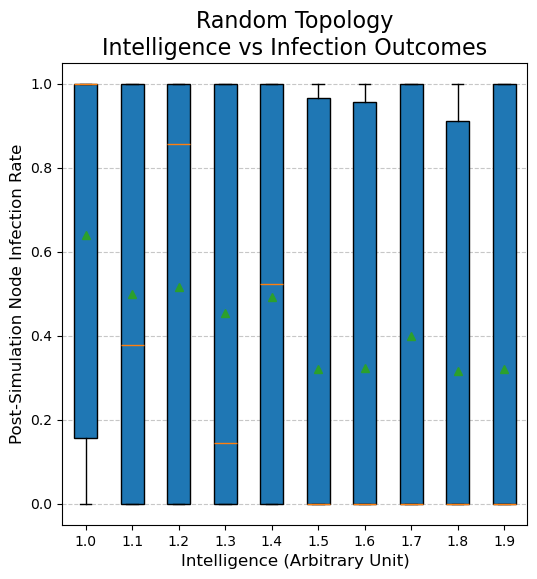

In [34]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

plt.title("Random Topology\nIntelligence vs Infection Outcomes", fontsize=16)
plt.xlabel("Intelligence (Arbitrary Unit)", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in intelligences]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/random-intelligences.png', dpi=600)
plt.show()

In [35]:
intelligences = np.arange(1, 2, 0.1)
infection_outcomes = []
for intelligence in intelligences: 
    # First, let's generate a bunch of topologies. 
    topology_batch = []
    for _ in range(25): 
        param = PopulationParameters(
            real_from_misinfor=-3.0 * (1 / intelligence), 
            real_from_real=1.0 * intelligence, 
            fake_from_factcheck=-2 * intelligence, 
            fake_from_real=-0.5 * intelligence)
        pop = Population("scalefree", pop_size=pop_size, c=4, pop_params=param)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(0.2 * pop_size)
        pop.add_factchecker_nodes(pop_size / 20)
        pop.add_misinfor_nodes(pop_size / 20)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results))
        
    infection_outcomes.append(results)    

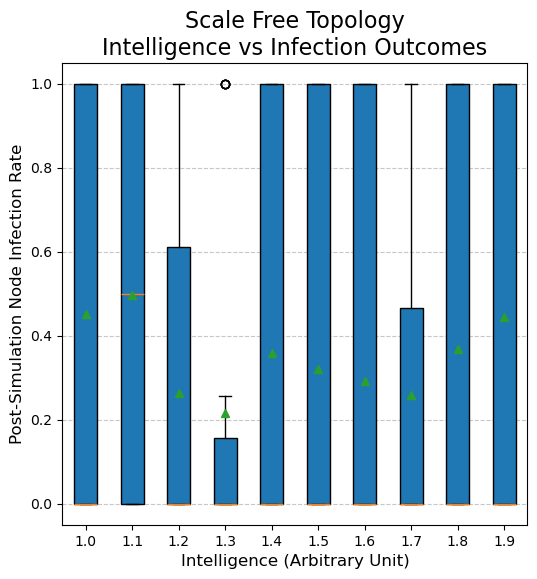

In [36]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

plt.title("Scale Free Topology\nIntelligence vs Infection Outcomes", fontsize=16)
plt.xlabel("Intelligence (Arbitrary Unit)", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in intelligences]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/scalefree-intelligences.png', dpi=600)
plt.show()

### Run 3.5: Understanding Spread of Fact Checkers

In [37]:
fact_checkers = np.arange(0, .7, 0.1)
infection_outcomes = []
for fact_checker in fact_checkers: 
    topology_batch = []
    for _ in range(25): 
        pop = Population("smallworld", pop_size=pop_size, c=6, p=0.1)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(0.2 * pop_size)
        pop.add_factchecker_nodes(fact_checker * pop_size)
        pop.add_misinfor_nodes(pop_size / 20)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results))
        
    infection_outcomes.append(results)    

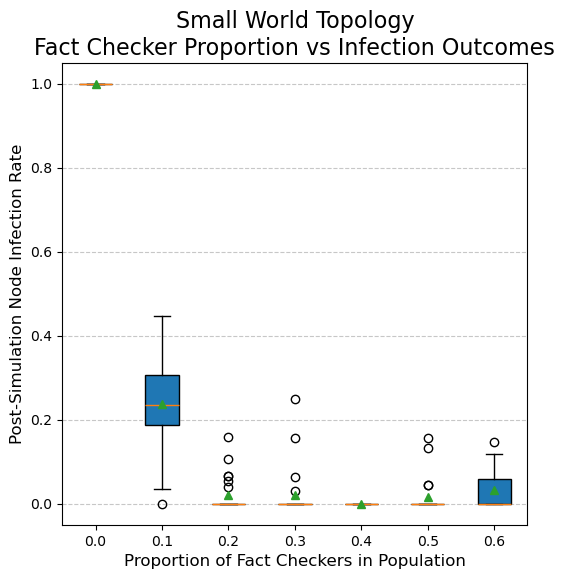

In [38]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

plt.title("Small World Topology\nFact Checker Proportion vs Infection Outcomes", fontsize=16)
plt.xlabel("Proportion of Fact Checkers in Population", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in fact_checkers]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/smallworld-factcheckers.png', dpi=600)
plt.show()

## Run 4: Understanding Jadedness

In [39]:
jaded_list = np.arange(1, 7, 0.5)
infection_outcomes = []
for jadedness in jaded_list: 
    # First, let's generate a bunch of topologies. 
    topology_batch = []
    for _ in range(25): 
        param = PopulationParameters(
            real_from_real=1.0 / jadedness, 
            fake_from_factcheck=-2 / jadedness, 
            factcheck_boost = 0.5 / jadedness, 
            misinfor_boost = 0.5 / jadedness,
            real_from_fake = 0.0 / jadedness, 
            fake_from_fake = 1.0 / jadedness, 
            real_from_misinfor = -3.0 / jadedness, 
            fake_from_real=-0.5 / jadedness)
        pop = Population("smallworld", pop_size=pop_size, c=6, p=0.1, pop_params=param)
        pop.set_all_nodes_realnews()
        pop.add_contig_fakenews_nodes(0.2 * pop_size)
        pop.add_factchecker_nodes(pop_size / 20)
        pop.add_misinfor_nodes(pop_size / 20)
        topology_batch.append(pop)
        
    with multiprocessing.Pool(processes=8) as pool: 
        results = pool.map(run_simulation, topology_batch)
        results = list(map(lambda x: x[-1], results))
        
    infection_outcomes.append(results)    

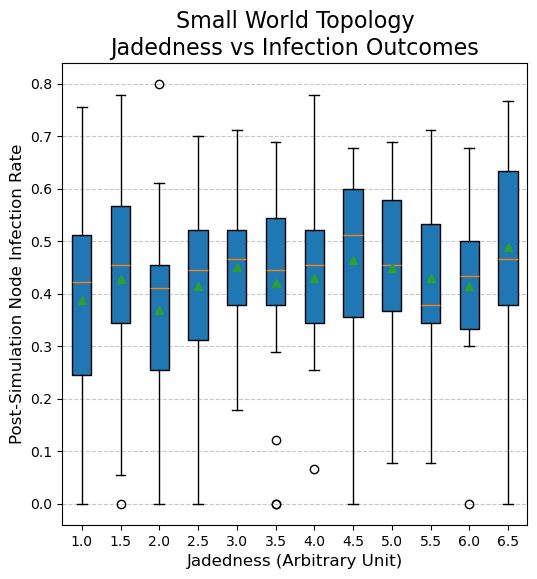

In [40]:
plt.figure(figsize=(6, 6))
plt.boxplot(infection_outcomes, patch_artist=True, showmeans=True)

plt.title("Small World Topology\nJadedness vs Infection Outcomes", fontsize=16)
plt.xlabel("Jadedness (Arbitrary Unit)", fontsize=12)
plt.ylabel("Post-Simulation Node Infection Rate", fontsize=12)
x_labels = [f"{x:.1f}" for x in jaded_list]
plt.xticks(ticks=range(1, len(infection_outcomes) + 1), labels=x_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('fig/smallworld-jaded.png', dpi=600)
plt.show()